In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import tensorflow as tf
flags = tf.app.flags
FLAGS = flags.FLAGS
flags.DEFINE_string('vocab', '/home/gezi/temp/textsum/tfrecord/seq-basic/train/vocab.txt', 'vocabulary file')

import sys, os, math
import gezi, melt
import numpy as np

from deepiu.util import text2ids

try:
    import conf  
    from conf import TEXT_MAX_WORDS, INPUT_TEXT_MAX_WORDS
except Exception:
    TEXT_MAX_WORDS = 20
    INPUT_TEXT_MAX_WORDS = 20
    
decode_max_words = 10

tensorflow_version: 1.2.0-rc0


In [3]:
def _text2ids(text, max_words):
  word_ids = text2ids.text2ids(text, 
                               seg_method='basic', 
                               feed_single=True, 
                               allow_all_zero=True, 
                               pad=False)
  #word_ids.append(text2ids.vocab.end_id())
  word_ids = word_ids[:max_words]
  word_ids = gezi.pad(word_ids, max_words, 0)

  return word_ids

In [4]:
from libgezi import utf82gbk, gbk2utf8
def predict(predictor, input_text, num_show=1):
  input_text = utf82gbk(input_text)
  word_ids = _text2ids(input_text, INPUT_TEXT_MAX_WORDS)
  print('word_ids', word_ids, 'len:', len(word_ids))
  print(gbk2utf8(text2ids.ids2text(word_ids)))

  timer = gezi.Timer()
  init_states = predictor.inference([
                                        'beam_search_beam_size',
                                        'beam_search_initial_state', 
                                        'beam_search_initial_ids', 
                                        'beam_search_initial_logprobs',
                                        'beam_search_initial_alignments'
                                        ], 
                                        feed_dict= {
                                          tf.get_collection('input_text_feed')[0] : [word_ids]
                                        })

  step_func = lambda input_feed, state_feed : predictor.inference([
                                        'beam_search_state', 
                                        'beam_search_ids', 
                                        'beam_search_logprobs',
                                        'beam_search_alignments', 
                                        ], 
                                        feed_dict= {
                                          #TODO...attetion still need input_text feed, see rnn_decoder.py  beam_search_step
                                          #but not hurt perfomance much because encoder is fast? Is it possible to avoid this?
                                          #anyway if no attention  will not need input_text_feed
                                          tf.get_collection('input_text_feed')[0] : [word_ids],
                                          tf.get_collection('beam_search_input_feed')[0] : input_feed,
                                          tf.get_collection('beam_search_state_feed')[0] : state_feed
                                        })

  max_words = decode_max_words if decode_max_words else TEXT_MAX_WORDS
  beams = melt.seq2seq.beam_search(init_states, 
                                   step_func, 
                                   end_id=text2ids.end_id(), 
                                   max_words=max_words, 
                                   length_normalization_factor=0.)

  #print(len(beams))
  #x_labels = [gbk2utf8(text2ids.vocab.key(x)).encode('utf8') for x in word_ids]
  for i, beam in enumerate(beams):
    if i == num_show:
      break
    print(gbk2utf8(text2ids.ids2text(word_ids)))
    print(i, beam.words, gbk2utf8(text2ids.ids2text(beam.words)), math.exp(beam.logprob), beam.logprob, beam.score, beam.logprobs)
    #print(beam.alignments_list)

    #plt.matshow(beam.alignments_list)
    
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(beam.alignments_list, interpolation='nearest')
    #fig.colorbar(cax)

    #ax.set_xticklabels(['']+x_labels)
    #ax.set_yticklabels(['']+alpha)

    plt.show()


  print('beam search using time(ms):', timer.elapsed_ms())

In [5]:
print(FLAGS.vocab)

/home/gezi/temp/textsum/tfrecord/seq-basic/train/vocab.txt


In [6]:
text2ids.init(FLAGS.vocab)
#model_dir='/home/gezi/temp/textsum/model.seq2seq.attention.encode_end/'
model_dir='/home/gezi/new/temp/textsum/model.seq2seq.attention'
predictor = melt.Predictor(model_dir)

def inference(text, num_show=1):
  predict(predictor, text, num_show=num_show)

ENCODE_UNK 1
restore from /home/gezi/new/temp/textsum/model.seq2seq.attention/model.ckpt-5.6-472000


INFO:tensorflow:Restoring parameters from /home/gezi/new/temp/textsum/model.seq2seq.attention/model.ckpt-5.6-472000


import graph ok /home/gezi/new/temp/textsum/model.seq2seq.attention/model.ckpt-5.6-472000.meta
restore ok /home/gezi/new/temp/textsum/model.seq2seq.attention/model.ckpt-5.6-472000


In [7]:
%%html
<style>
.output_wrapper, .output {
    height:auto !important;
    max-height:10000px;  /* your desired max-height here */
}
.output_scroll {
    box-shadow:none !important;
    webkit-box-shadow:none !important;
}
</style>

word_ids [5143, 5088, 7316, 532, 13, 691, 742, 805, 5143, 5088, 7316, 532, 13, 11810, 16506, 0, 0, 0, 0, 0] len: 20
大棚/辣椒/果实/变/小/怎么/办/,/大棚/辣椒/果实/变/小/防治/措施
大棚/辣椒/果实/变/小/怎么/办/,/大棚/辣椒/果实/变/小/防治/措施
0 [5088, 5088, 1] 辣椒/辣椒/<EOS> 0.0172721807136 -4.05866 -4.05866 [-1.0340832, -1.9163737, -1.108201]


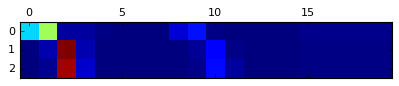

beam search using time(ms): 864.681005478
word_ids [214, 899, 322, 1866, 949, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] len: 20
你/去/打/篮球/吗
你/去/打/篮球/吗
0 [322, 1866, 1] 打/篮球/<EOS> 0.0814828003712 -2.50736 -2.50736 [-0.9823252, -0.0094132628, -1.515625]


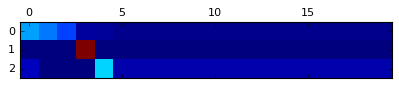

beam search using time(ms): 259.924173355
word_ids [322, 1866, 214, 899, 949, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] len: 20
打/篮球/你/去/吗
打/篮球/你/去/吗
0 [322, 1866, 1] 打/篮球/<EOS> 0.149594442813 -1.89983 -1.89983 [-0.45060667, -0.013775986, -1.4354447]


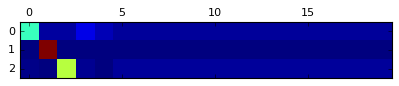

beam search using time(ms): 281.10408783
word_ids [1492, 210, 267, 244, 655, 8, 22731, 80, 40621, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] len: 20
这/是/周/华/健/的/新歌/爱/相随
这/是/周/华/健/的/新歌/爱/相随
0 [267, 244, 655, 1] 周/华/健/<EOS> 0.14283668194 -1.94605 -1.94605 [-0.51488763, -0.093376815, -0.08689557, -1.2508934]


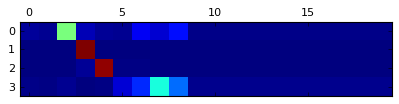

beam search using time(ms): 242.229938507
word_ids [25394, 84, 2743, 19, 807, 752, 805, 31304, 3123, 84, 2102, 1804, 0, 0, 0, 0, 0, 0, 0, 0] len: 20
年少/不/懂/高/晓/松/,/读懂/已/不/再/少年
年少/不/懂/高/晓/松/,/读懂/已/不/再/少年
0 [19, 807, 752, 1] 高/晓/松/<EOS> 0.00562897357494 -5.17983 -5.17983 [-2.9566283, -0.94283223, -0.067018993, -1.2133485]


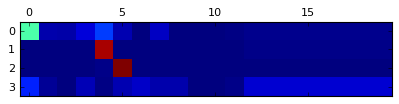

beam search using time(ms): 247.912883759
word_ids [60, 811, 2742, 235, 949, 3383, 60, 811, 2742, 2841, 1679, 57, 0, 0, 0, 0, 0, 0, 0, 0] len: 20
王/凯/整容/了/吗/_/王/凯/整容/前后/对比/照片
王/凯/整容/了/吗/_/王/凯/整容/前后/对比/照片
0 [60, 811, 2742, 2841, 1679, 1] 王/凯/整容/前后/对比/<EOS> 0.0754955486001 -2.58368 -2.58368 [-0.31663299, -0.012344858, -0.46544558, -0.32847193, -0.65292352, -0.80786288]


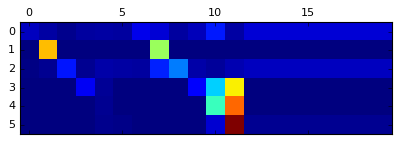

beam search using time(ms): 254.379987717
word_ids [6423, 1083, 5327, 226, 24332, 668, 668, 163, 13, 4073, 62, 107, 0, 0, 0, 0, 0, 0, 0, 0] len: 20
【/贴图/】/韩/敏英/-/-/性感/小/吊带/黑/丝
【/贴图/】/韩/敏英/-/-/性感/小/吊带/黑/丝
0 [163, 62, 107, 1] 性感/黑/丝/<EOS> 0.00832876443336 -4.78804 -4.78804 [-1.8791311, -1.4570832, -0.026183745, -1.4256419]


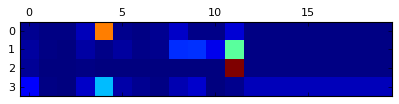

beam search using time(ms): 253.045082092
word_ids [1672, 485, 3243, 533, 392, 5154, 8, 1733, 16400, 670, 1817, 36325, 7, 1311, 148, 7, 31396, 213, 1343, 872] len: 20
彭/于/晏/都/力/荐/的/《/寒战/2/》/imax/ /3d/版/ /华龙/网/送/票
彭/于/晏/都/力/荐/的/《/寒战/2/》/imax/ /3d/版/ /华龙/网/送/票
0 [16400, 670, 1] 寒战/2/<EOS> 0.00970673427668 -4.63494 -4.63494 [-2.6846735, -0.50302523, -1.4472368]


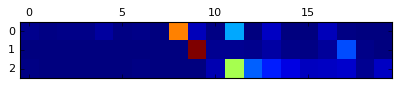

beam search using time(ms): 240.628004074
word_ids [37, 14356, 7, 16948, 1513, 1481, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] len: 20
美女/劈叉/ /鼻血/狂/喷
美女/劈叉/ /鼻血/狂/喷
0 [37, 14356, 1] 美女/劈叉/<EOS> 0.0171671871717 -4.06476 -4.06476 [-0.81995165, -2.5655601, -0.67924339]


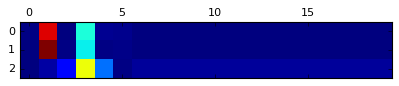

beam search using time(ms): 239.534854889
word_ids [1817, 7, 1252, 228, 7, 4006, 228, 7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] len: 20
》/ /卫生/间/ /洗手/间/ 
》/ /卫生/间/ /洗手/间/ 
0 [1252, 228, 4006, 228, 1] 卫生/间/洗手/间/<EOS> 0.112863542877 -2.18158 -2.18158 [-0.49758226, -0.0016349294, -0.4926827, -0.035448737, -1.1542273]


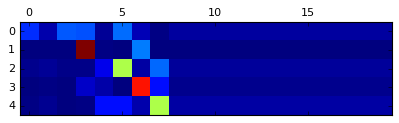

beam search using time(ms): 256.552934647
word_ids [2234, 7, 3885, 4193, 828, 146, 30, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] len: 20
iphone/ /6s/耐克/主题/手机/壁纸
iphone/ /6s/耐克/主题/手机/壁纸
0 [5483, 9597, 30, 1] iphon/e7/壁纸/<EOS> 0.00944431270913 -4.66234 -4.66234 [-1.6872231, -1.4536031, -0.92477411, -0.59674203]


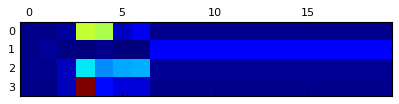

beam search using time(ms): 246.944189072


In [8]:
predict(predictor, "大棚辣椒果实变小怎么办,大棚辣椒果实变小防治措施")
predict(predictor, '你去打篮球吗')
predict(predictor, '打篮球你去吗')
predict(predictor, '这是周华健的新歌爱相随')
inference('年少不懂高晓松,读懂已不再少年')
inference('王凯整容了吗_王凯整容前后对比照片')
inference('【贴图】韩敏英--性感小吊带黑丝')
inference('彭于晏都力荐的《寒战2》imax 3d版 华龙网送票邀你提前看')
inference('美女劈叉 鼻血狂喷')
inference('》 卫生间 洗手间 ')
inference('iphone 6s耐克主题手机壁纸')

word_ids [8246, 9974, 1298, 426, 775, 448, 2238, 1800, 88, 2340, 7, 0, 0, 0, 0, 0, 0, 0, 0, 0] len: 20
蜀山/战纪/赵丽/颖/古装/剧照/(/12/张/)/ 
蜀山/战纪/赵丽/颖/古装/剧照/(/12/张/)/ 
0 [1298, 426, 775, 1] 赵丽/颖/古装/<EOS> 0.042037306802 -3.1692 -3.1692 [-0.23566402, -0.0079425219, -0.98168576, -1.9439055]


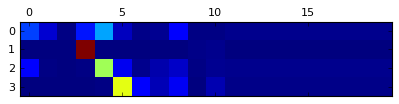

beam search using time(ms): 239.309072495


In [9]:
inference('蜀山战纪赵丽颖古装剧照(12张) ')

word_ids [323, 56, 758, 45, 301, 9147, 1733, 410, 570, 1100, 8, 6091, 1817, 0, 0, 0, 0, 0, 0, 0] len: 20
幼儿/园/动物/简/笔画/教案/《/两/条/漂亮/的/小鱼/》
幼儿/园/动物/简/笔画/教案/《/两/条/漂亮/的/小鱼/》
0 [323, 56, 45, 301, 1] 幼儿/园/简/笔画/<EOS> 0.0177916754757 -4.02902 -4.02902 [-1.3086596, -0.055808205, -1.216213, -0.031905945, -1.4164379]


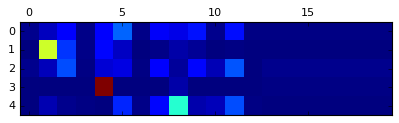

beam search using time(ms): 247.798919678


In [10]:
inference('幼儿园动物简笔画教案《两条漂亮的小鱼》')

word_ids [334, 595, 85, 1034, 11, 5593, 121, 389, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] len: 20
第/六/感/美甲/美/睫/纹/秀
第/六/感/美甲/美/睫/纹/秀
0 [1034, 1] 美甲/<EOS> 0.0146823470137 -4.22111 -4.22111 [-0.36908352, -3.8520257]


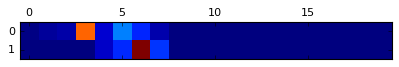

beam search using time(ms): 275.681972504


In [11]:
inference('第六感美甲美睫纹秀')

word_ids [4305, 5762, 3136, 5697, 2060, 389, 1961, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] len: 20
2013/春夏/男装/米兰/时装/秀/9
2013/春夏/男装/米兰/时装/秀/9
0 [2060, 389, 1] 时装/秀/<EOS> 0.109287239864 -2.21378 -2.21378 [-1.0156739, -0.041885693, -1.1562161]


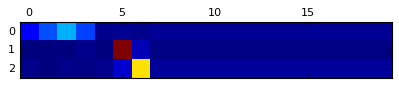

beam search using time(ms): 268.267154694


In [12]:
inference('2013春夏男装米兰时装秀9')

word_ids [772, 7630, 67, 89652, 8, 19841, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] len: 20
关于/房价/最/透彻/的/解读
关于/房价/最/透彻/的/解读
0 [7630, 1] 房价/<EOS> 0.00503902532983 -5.29054 -5.29054 [-2.9083226, -2.3822198]


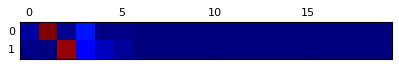

beam search using time(ms): 256.102085114


In [13]:
inference('关于房价最透彻的解读')

word_ids [4667, 630, 7902, 51, 1297, 10515, 4961, 7170, 16504, 3467, 25032, 0, 0, 0, 0, 0, 0, 0, 0, 0] len: 20
辽宁/省/中小/学/教师/职称/制度/改革/实施/方案/出台
辽宁/省/中小/学/教师/职称/制度/改革/实施/方案/出台
0 [7902, 51, 1] 中小/学/<EOS> 0.000823598713693 -7.10183 -7.10183 [-3.2619138, -0.020112855, -3.8198006]


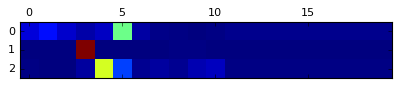

beam search using time(ms): 251.727819443


In [14]:
inference('辽宁省中小学教师职称制度改革实施方案出台')

word_ids [4470, 452, 208, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] len: 20
骷髅/情侣/纹身
骷髅/情侣/纹身
0 [4470, 208, 1] 骷髅/纹身/<EOS> 0.0298704175137 -3.51089 -3.51089 [-1.7429206, -0.68715751, -1.0808086]


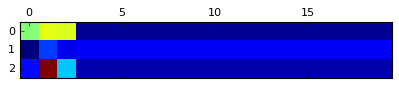

beam search using time(ms): 237.934112549


In [15]:
inference('骷髅情侣纹身')

word_ids [42999, 869, 1474, 363, 8, 164, 926, 649, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] len: 20
酷似/朴/姬/兰/的/刘/亦/菲
酷似/朴/姬/兰/的/刘/亦/菲
0 [164, 926, 649, 1] 刘/亦/菲/<EOS> 0.0381138486301 -3.26718 -3.26718 [-0.77247036, -0.0051094666, -0.0053949007, -2.4842029]


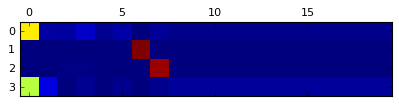

酷似/朴/姬/兰/的/刘/亦/菲
1 [164, 926, 649, 6, 1] 刘/亦/菲/图片/<EOS> 0.0118294525778 -4.43716 -4.43716 [-0.77247036, -0.0051094666, -0.0053949007, -2.9233356, -0.73085254]


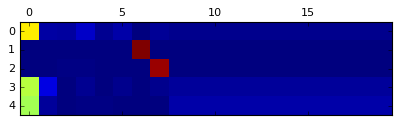

beam search using time(ms): 314.420938492


In [16]:
inference('酷似朴姬兰的刘亦菲', 2)

word_ids [42999, 164, 926, 649, 8, 869, 1474, 363, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] len: 20
酷似/刘/亦/菲/的/朴/姬/兰
酷似/刘/亦/菲/的/朴/姬/兰
0 [164, 926, 649, 1] 刘/亦/菲/<EOS> 0.0305127929756 -3.48961 -3.48961 [-1.2320521, -0.0088598477, -0.0065049096, -2.2421923]


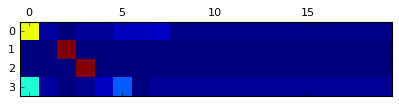

酷似/刘/亦/菲/的/朴/姬/兰
1 [164, 926, 649, 6, 1] 刘/亦/菲/图片/<EOS> 0.00984981899295 -4.6203 -4.6203 [-1.2320521, -0.0088598477, -0.0065049096, -2.7463427, -0.62654257]


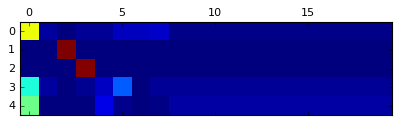

酷似/刘/亦/菲/的/朴/姬/兰
2 [869, 1474, 363, 1] 朴/姬/兰/<EOS> 0.00271257401703 -5.90986 -5.90986 [-3.3330967, -1.1258752, -0.32032639, -1.1305591]


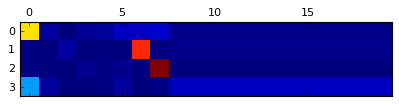

酷似/刘/亦/菲/的/朴/姬/兰
3 [396, 926, 649, 1] 吴/亦/菲/<EOS> 0.00189520398491 -6.26843 -6.26843 [-4.081912, -0.052877557, -0.014839857, -2.1187999]


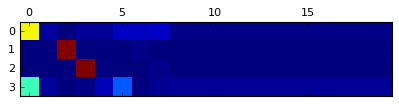

酷似/刘/亦/菲/的/朴/姬/兰
4 [164, 926, 649, 6, 42, 1] 刘/亦/菲/图片/大全/<EOS> 0.00149843857772 -6.50333 -6.50333 [-1.2320521, -0.0088598477, -0.0065049096, -2.7463427, -2.0121074, -0.49746475]


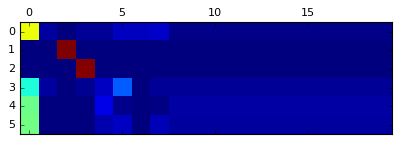

beam search using time(ms): 627.259016037


In [17]:
inference('酷似刘亦菲的朴姬兰', 5)

word_ids [97, 80, 322, 1866, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] len: 20
我/爱/打/篮球
我/爱/打/篮球
0 [322, 1866, 1] 打/篮球/<EOS> 0.0326035804127 -3.42333 -3.42333 [-1.8857857, -0.0087244296, -1.528823]


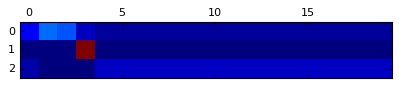

beam search using time(ms): 276.20100975


In [18]:
inference('我爱打篮球')

word_ids [322, 1866, 181, 84, 181, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] len: 20
打/篮球/好/不/好
打/篮球/好/不/好
0 [322, 1866, 1] 打/篮球/<EOS> 0.0856481128989 -2.45751 -2.45751 [-0.78580993, -0.0090089515, -1.6626892]


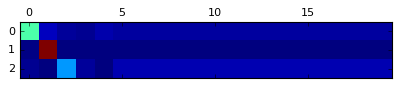

beam search using time(ms): 244.143009186


In [19]:
inference('打篮球好不好')

word_ids [1236, 682, 4349, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] len: 20
帅哥/戴/墨镜
帅哥/戴/墨镜
0 [1236, 682, 4349, 1] 帅哥/戴/墨镜/<EOS> 0.0902767974097 -2.40487 -2.40487 [-0.92268401, -0.22355011, -0.36983174, -0.88880891]


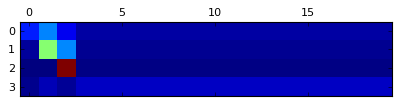

beam search using time(ms): 254.538059235


In [20]:
inference('帅哥戴墨镜')

word_ids [27135, 7, 1614, 6577, 8, 157, 10898, 21077, 7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] len: 20
厄瓜多尔/ /美丽/神秘/的/南/美洲/国度/ 
厄瓜多尔/ /美丽/神秘/的/南/美洲/国度/ 
0 [157, 10898, 1] 南/美洲/<EOS> 0.017797988492 -4.02867 -4.02867 [-2.2616525, -0.39304101, -1.3739763]


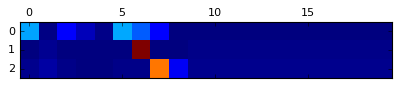

厄瓜多尔/ /美丽/神秘/的/南/美洲/国度/ 
1 [20, 1] <UNK>/<EOS> 0.0086737324963 -4.74746 -4.74746 [-4.2433438, -0.50411242]


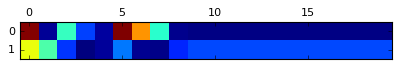

厄瓜多尔/ /美丽/神秘/的/南/美洲/国度/ 
2 [5974, 1] 澳大利亚/<EOS> 0.00628333281451 -5.06985 -5.06985 [-2.737658, -2.332197]


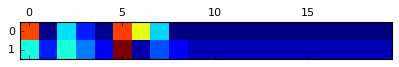

beam search using time(ms): 480.838060379


In [22]:
inference('厄瓜多尔 美丽神秘的南美洲国度 ', 3)

word_ids [1672, 485, 3243, 533, 392, 5154, 8, 1733, 16400, 670, 1817, 36325, 7, 1311, 148, 7, 31396, 213, 1343, 872] len: 20
彭/于/晏/都/力/荐/的/《/寒战/2/》/imax/ /3d/版/ /华龙/网/送/票
彭/于/晏/都/力/荐/的/《/寒战/2/》/imax/ /3d/版/ /华龙/网/送/票
0 [16400, 670, 1] 寒战/2/<EOS> 0.0097067203911 -4.63494 -4.63494 [-2.6846738, -0.50302607, -1.4472371]


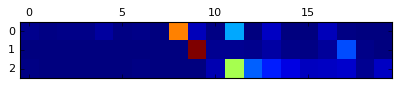

彭/于/晏/都/力/荐/的/《/寒战/2/》/imax/ /3d/版/ /华龙/网/送/票
1 [1672, 485, 3243, 1] 彭/于/晏/<EOS> 0.00796168495292 -4.83311 -4.83311 [-2.2092881, -0.009646941, -0.16386098, -2.4503186]


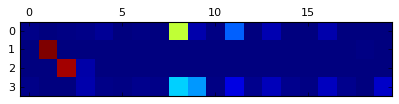

彭/于/晏/都/力/荐/的/《/寒战/2/》/imax/ /3d/版/ /华龙/网/送/票
2 [20, 1] <UNK>/<EOS> 0.00534400422477 -5.23178 -5.23178 [-4.2781253, -0.95365489]


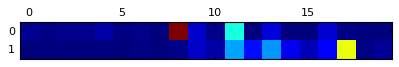

beam search using time(ms): 523.085832596


In [23]:
inference('彭于晏都力荐的《寒战2》imax 3d版 华龙网送票邀你提前看', 3)